#Vorbereitung der Umgebung 
Bereitet die Umgebung vor, lädt die nötigen Dependencies und Libraries die im Projekt benötigt werden.

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install shap
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

from scipy.ndimage import median_filter
from scipy.signal import wiener
from pykalman import KalmanFilter

#Umwandlung JSON-Request zu CSV
Dieser Code muss nur ausgeführt werden, wenn die Erhebung von Referenzdaten statt mit dem Beacon Backend Projekt, mit hook.ubeac.io erfasst wurden. In diesem Codesegment werden die JSON-Files verarbeitet und die Informationen so aufbereitet, dass diese zu denselben CSV-Files führen wie bei dem Beacon Backend Projekt.

In [ ]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/"

whitelist_majorminor = [100029571,100029586,100656666,1000411111,1000422222,1000454480,1230329194]

os.chdir(path+"JSON/")
dictionary_list = []

for json_file in glob.glob("*.json"):
  filename = os.path.splitext(json_file)[0]

  df = pd.read_json(path+"/JSON/"+filename+".json",)

  #Iterates through all gateway traces
  for trace_index in range(len(df)):
    current_trace = df.iloc[trace_index]
    
    #Splits data string as it is not castable as json string
    #Two step is required to filter out , signs
    trace_entries = current_trace.content.split('"')[3::2]
    for beacon_index in range(len(trace_entries)):
      beacon_data = trace_entries[beacon_index].split(',')

      if len(beacon_data[4]) >= 56: 
        #Extracts beacon data out of hex value
        beacon_type = beacon_data[4][6:18]
        uuid = beacon_data[4][18:50]
        major = int(beacon_data[4][50:54],16)
        minor = int(beacon_data[4][54:58],16)
        majorminor = int(str(major)+str(minor))
        timestamp = beacon_data[5]

        #Checks if current iteration should be skipped as signal is not of beacons
        if majorminor not in whitelist_majorminor:
          continue
        #General signal power strength set for beacons
        #The measured power equals the signal strength on 1 meter distance
        measured_power = -60

        #Specific power was set for beacon with the majorminor value (100656666)
        if majorminor == 100656666:
          measured_power = -75

        #Id of the tag of the Beacon
        tag_id = beacon_data[1]
        gateway = beacon_data[2]
        rssi = int(beacon_data[3])
        
        #Calculates distance with given formula
        distance = (10 ** ((measured_power - rssi) / (10 * 3)))

        #Creates beacon entry as dictionary entry for efficent dataframe transformation
        beacon = {'_id':tag_id, 'distance':distance, 'gateway':gateway, 
                'major':major, 'majorminor':majorminor, 'minor':minor, 
                'rssi':rssi, 'timestamp':timestamp,'type':beacon_type,
                'uuid':uuid}
        #Adds beacon to dictionary
        dictionary_list.append(beacon)
#Transforms dicitonary to dataframe (more efficent then concat)
transformed_df = pd.DataFrame.from_dict(dictionary_list)

#Cleaning of dublicates / multi entries which were recived with same timestamp
transformed_df[["distance","rssi"]] = transformed_df.groupby(["timestamp","majorminor","gateway","uuid"])[["distance","rssi"]].transform('median')
transformed_df = transformed_df.drop_duplicates().sort_values(by=["timestamp","gateway"]).reset_index(drop=True)

transformed_df.to_csv(r''+path+"/CSV/CombinedGatewayData.csv", index=False)

#Labeling der Daten (Erweiterung CSV)
In diesem Abschnitt werden die CSV-Dateien welche aus JSON-Requests oder direkt aus einer Datenbank extrahiert wurden mit Labeln erweitert.
Hier zu muss ein LabelHelper.csv File ausgefüllt werden, da diese die Zeitpünkte / Timestamps enthalten man sich wann an welchem Punkt befunden hat um das entsprechende Label zu setzen.

In [ ]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/"
path_csv = path+"CSV/"

#Contains timestamp, tag and specific tag values for each measurepoint of data
timestamp_label_hepler_df = pd.read_csv(path+"LabelHelper.csv",sep=";")

os.chdir(path_csv)

frame = list()

for csv_file in glob.glob("*.csv"):
  df = pd.read_csv(path_csv + csv_file)

  #This iterates through all data which are within the valid timestamp which are defined in a helper csv file
  for index in range(len(timestamp_label_hepler_df)):
    selection = df.loc[(df.timestamp >= timestamp_label_hepler_df.iloc[index].firsttimestamp) & 
                       (df.timestamp <= timestamp_label_hepler_df.iloc[index].lasttimestamp)].copy()
    selection[["tag","specificTag"]] = timestamp_label_hepler_df.iloc[index][["tag", "specificTag"]]
    frame.append(selection)
  
master_df = pd.concat(frame).drop_duplicates().reset_index(drop=True)
master_df.to_csv(r''+path_csv+"LabeledCombinedGatewayData.csv", index=False)
master_df.head()

,_id,distance,gateway,major,majorminor,minor,rssi,timestamp,type,uuid,tag,specificTag
0,F0F8F2044F23,0.980121,E06B09BAC79F,10004,1000422222,22222,-59.5,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1
1,DC0D300F720A,1.359356,E06B09BAC79F,12303,1230329194,29194,-64.0,1679222510,1AFF4C000215,D546DF97475747EFBE093E2DCBDD0C77,Room1,M1
2,C630A073DD08,1.107925,E06B09BAC79F,10002,100029586,9586,-60.0,1679222510,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Room1,M1
3,087CBF000028,1.847850,E06B09BAC79F,10004,1000411111,11111,-68.0,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1
4,04EE03C47286,0.857696,E06B09BAC79F,10004,1000454480,54480,-58.0,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1


#Rohdatenanalyse
In diesem Abschnitt werden die grob aufbereiten Daten eingelesen und visuell aufbereitet um dies zu analysieren.

In [16]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
features = ["distance","rssi","gateway"]
join_parameter = ["type","uuid","tag","specificTag","timestamp","major","majorminor","minor"]

#Training
filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv"
#Test closed Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv"
#Test open Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv"


master_df = pd.read_csv(filepath)

#Dinamical adapting on number of gateways used for experiment
gateways = master_df.gateway.unique()

#Creating new Dataframes
adapted_master_df = pd.DataFrame()
temp_df = pd.DataFrame()

#Repeat until every Timestamp and Gateway have combined / adapted to oneanother
for gateway in gateways:
  beacon_measurements_of_gateway_df = master_df.loc[(master_df.gateway == gateway)].copy()
  #Columns which could be used as feature are expanded with Name of Gateway as suffix
  beacon_measurements_of_gateway_df.columns = [col + '_' + gateway if col in features else col for col in beacon_measurements_of_gateway_df.columns]
    
  #Checks if temp Dataframe already has entries and has to be merged or a copy is "dumped" in
  if len(temp_df) > 0:
    temp_df = pd.merge(temp_df,beacon_measurements_of_gateway_df, how='outer', on=join_parameter)
  else:
    temp_df = beacon_measurements_of_gateway_df.copy()
adapted_master_df = pd.concat([adapted_master_df, temp_df])
adapted_master_df.drop_duplicates(inplace=True)
temp_df.drop(temp_df.index , inplace=True)
adapted_master_df.reset_index(drop=True, inplace=True)

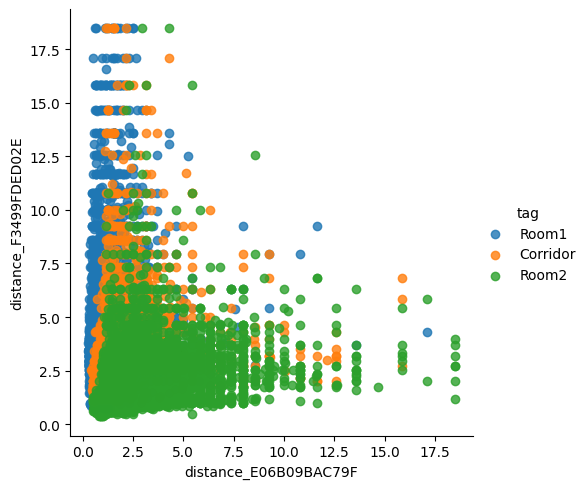

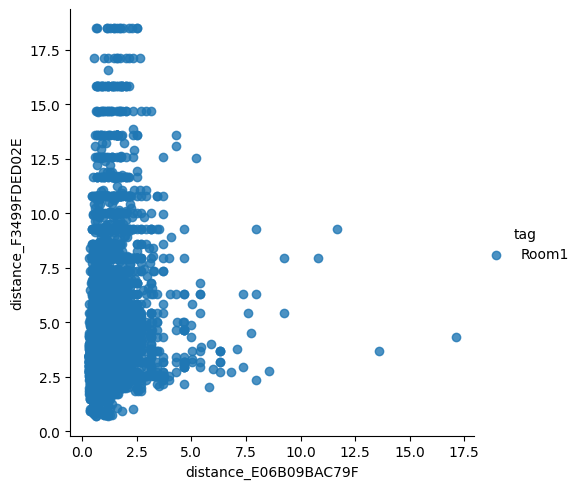

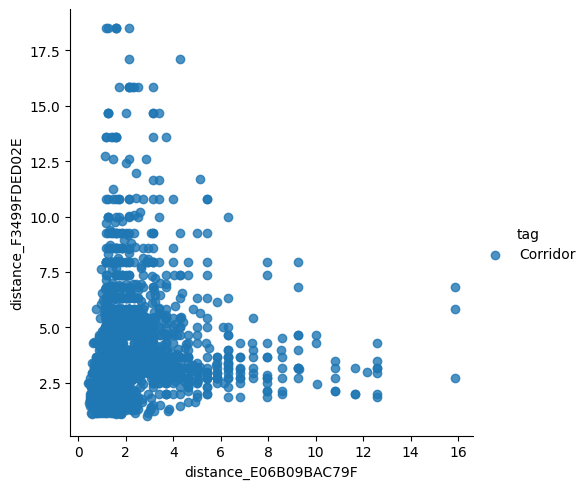

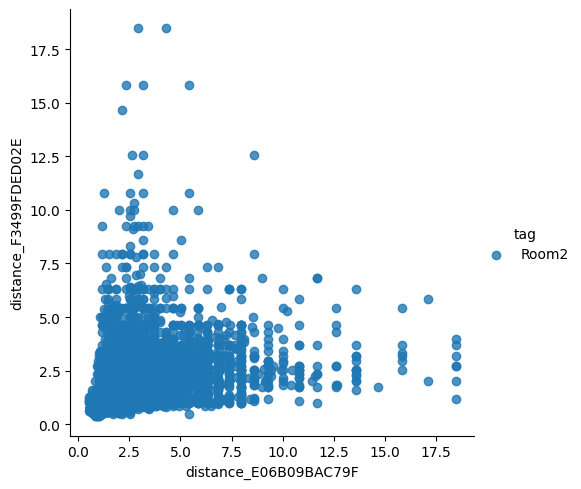

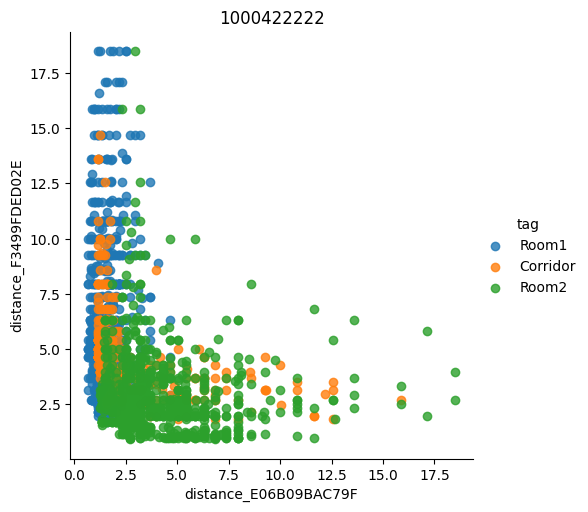

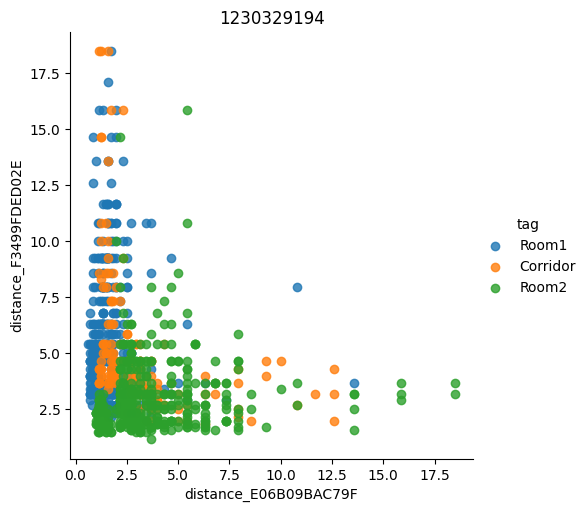

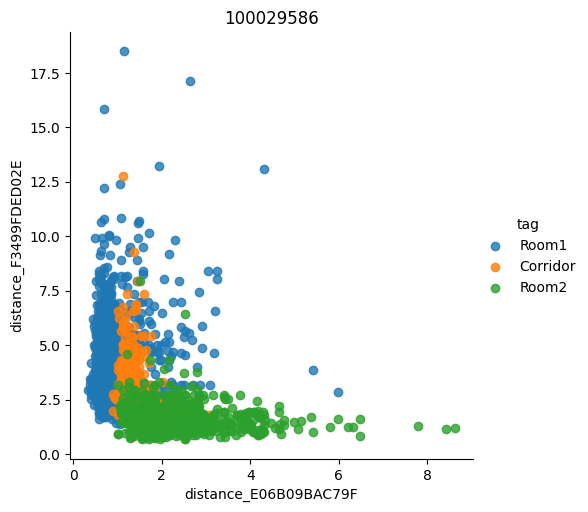

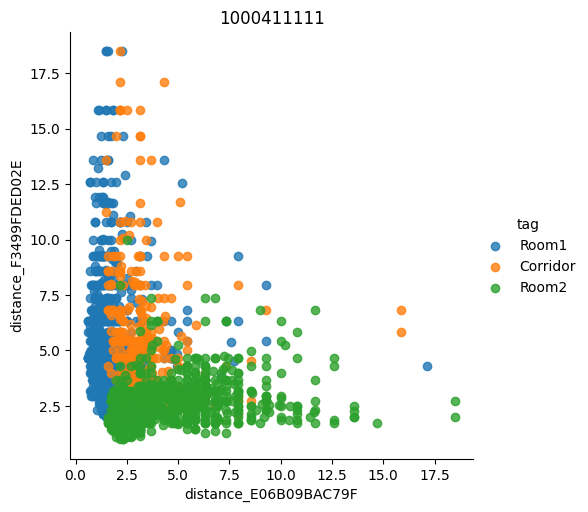

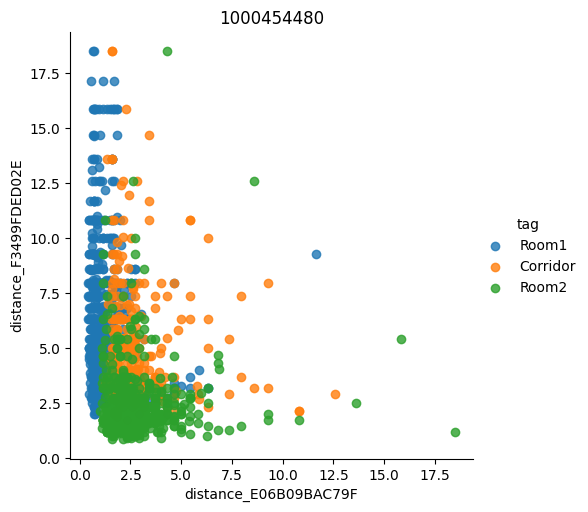

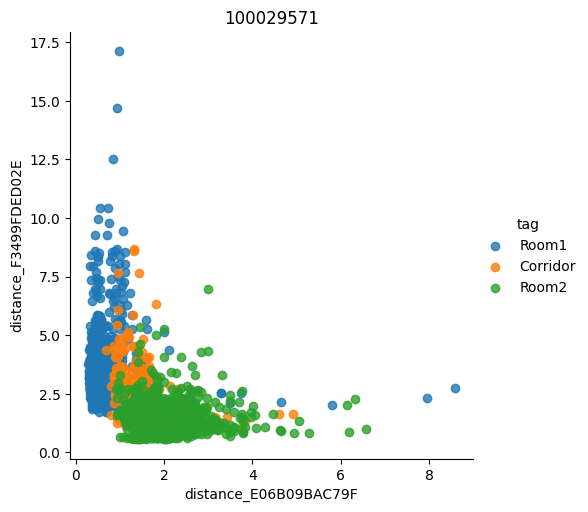

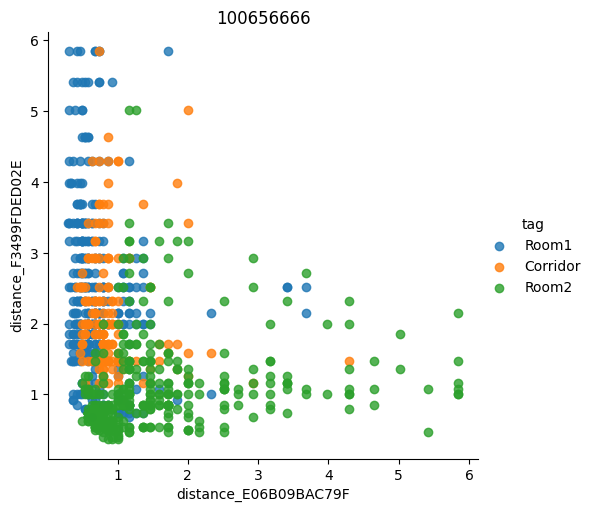

In [17]:
#Selects all columns that start with distance
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adapted_master_df, hue='tag', fit_reg=False)
for tag in adapted_master_df.tag.unique():
  sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adapted_master_df.loc[adapted_master_df.tag==tag], hue='tag', fit_reg=False)

plt.show()

for majorminor in adapted_master_df.majorminor.unique():
  df = adapted_master_df.loc[adapted_master_df.majorminor == majorminor]
  sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=df, hue='tag', fit_reg=False)
  plt.title(majorminor)
  
plt.show()
#for tag in adapted_master_df.tag.unique():
#  df = adapted_master_df.loc[adapted_master_df.tag == tag]
#  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=df, hue='specificTag', fit_reg=False)
#  plt.show()

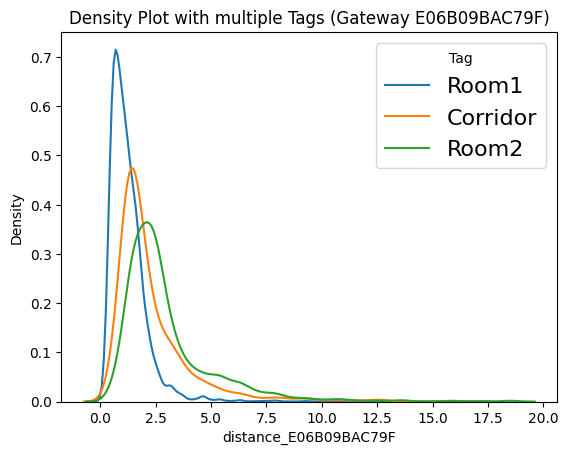

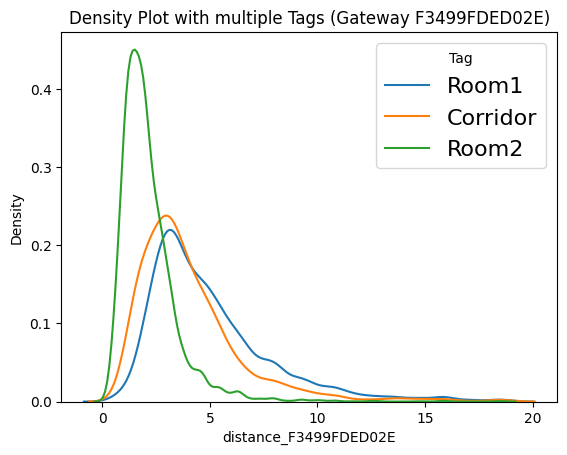

In [18]:
#Gets all tags (can be modified to spefic tags etc)
tags = adapted_master_df.tag.unique()
#Selects all columns that start with distance
distance_column_names = [column for column in adapted_master_df.columns if column.startswith("distance")]

for distance_column in distance_column_names:
  #Iterates through the tags
  for tag in tags:
    #Subset to the specific tag
    subset = adapted_master_df[adapted_master_df['tag'] == tag]
    
    #Draw density plot
    sns.kdeplot(subset[distance_column], label = tag)
    
  #Plot formatting
  plt.legend(prop={'size': 16}, title = 'Tag')
  plt.title('Density Plot with multiple Tags (Gateway '+distance_column.split('_')[1]+')')
  plt.xlabel(distance_column)
  plt.ylabel('Density')
  plt.show()

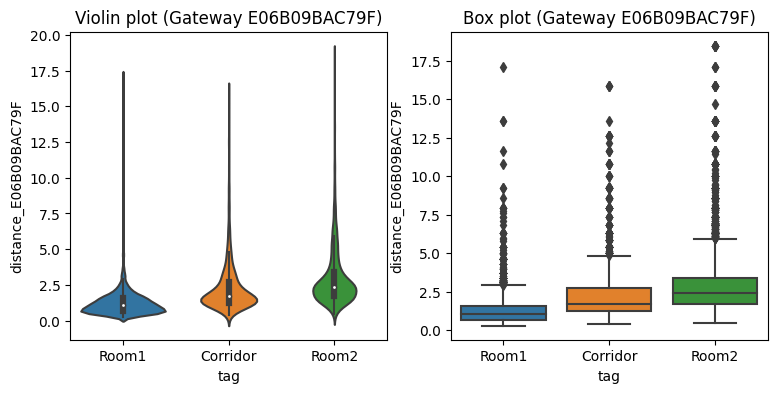

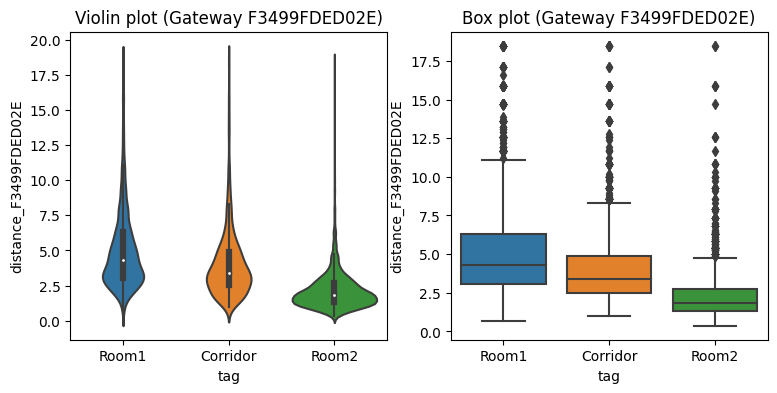

In [19]:
distance_column_names = [column for column in adapted_master_df.columns if column.startswith("distance")]

for distance_column in distance_column_names:
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
  
  #Plot violin plot
  asdf = sns.violinplot(ax=axs[0], x='tag', y=distance_column, data=adapted_master_df)
  axs[0].set_title('Violin plot (Gateway '+distance_column.split('_')[1]+')')

  #Plot box plot
  sns.boxplot(ax=axs[1], x='tag', y=distance_column, data=adapted_master_df)
  axs[1].set_title('Box plot (Gateway '+distance_column.split('_')[1]+')')

  plt.show()

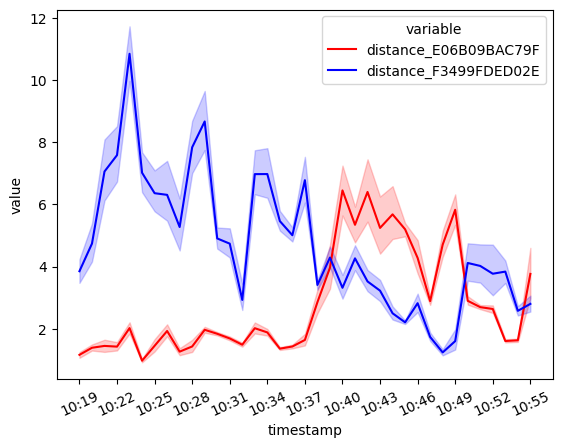

In [20]:
majorminor = adapted_master_df.majorminor.unique()
df = adapted_master_df.loc[adapted_master_df.majorminor == majorminor[0],(distance_column_names + ["timestamp"])]
df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')
sample = sns.lineplot(x='timestamp', y='value', hue='variable', 
             data=pd.melt(df, ['timestamp']),
             palette=['red', 'blue'])
             #estimator="median")
sample.set_xticks(sample.get_xticks()[::3])
sample.set_xticklabels(sample.get_xticklabels(), rotation=25)
plt.show()

#Dateneinlesen und -grobaufbereitung
In diesem Abschnitt werden die Daten so aufbereitet, dass diese auf die Modelle angewendet werden können. Sowohl als Trainings- und Testdaten.  

In [25]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
columns_of_interessts = ["distance","gateway","uuid","majorminor","timestamp","tag","specificTag"]

#Mapping used to adapt the current tags with new labels ("InRoom": True / False)
gateway_to_tag = {'E06B09BAC79F':'Room1', 'F3499FDED02E':'Room2'}

#Create new master dicitonary seperated by gateways
master_dict = dict()

#Training
filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv"
#Test closed Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv"
#Test open Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv"

#Load and secure clean data
master_df = pd.read_csv(filepath).drop_duplicates().reset_index(drop=True)

#Load Gateways
gateways = master_df.gateway.unique()

for gateway in gateways:
  temp_df = master_df.loc[master_df.gateway == gateway].copy()
  temp_df.distance = temp_df.distance.round(3)
  temp_df['InRoom'] = [1 if (gateway_to_tag.get(gateway) == tag) else 0 for tag in temp_df.tag]
  master_dict[gateway] = {'data': temp_df}

#Datenfilterung, -aufbereitung und non Machine Learning Ansatz
In diesem Bereich werden unterschiedliche Filter für die Datenaufbereitung genutzt und verglichen. Anhand diesen Filtern soll auch eine erste **non** Machine Learning Modell erstellt werden. Dies kann auch für die darauffolgenden Modellen als Benchmark verwendet werden.

In [29]:
#Define window size for filter
window_size = 10

distance_raw = 'distance'
distance_moving_median = 'distance_MMedian'
distance_moving_mean = 'distance_MMean'
distance_wiener = 'distance_Wiener'
distance_kalman = 'distance_Kalman'

dict_filter_distance_columns = {'Raw':distance_raw, 'MMedian': distance_moving_median, 'MMean': distance_moving_mean,
                     'Wiener': distance_wiener, 'Kalman': distance_kalman}

for gateway in master_dict.keys():
  temp_df = master_dict[gateway]['data']
  for majorminor in temp_df.majorminor.unique():
    distance = temp_df.loc[(temp_df.majorminor == majorminor)].distance
    #Moving Median filter
    array_distance_moving_median = distance.rolling(window=window_size).median().to_numpy()
    temp_df.loc[(temp_df.majorminor == majorminor), distance_moving_median] = array_distance_moving_median.round(3)
    #Sliding Window / moving mean filter
    array_distance_moving_mean = distance.rolling(window=window_size).mean().to_numpy()
    temp_df.loc[(temp_df.majorminor == majorminor), distance_moving_mean] = array_distance_moving_mean.round(3)
  
    #Wiener Filter
    array_distance_wiener = wiener(distance.to_numpy(),mysize=window_size)
    temp_df.loc[(temp_df.majorminor == majorminor), distance_wiener] = array_distance_wiener.round(3)
  
    #Kalman filter
    #Uses standard setting and EM algorithmen to optimize em variables such as via .em function
    #transition_covariance, observation_covariance, initial_state_mean and initial_state_covariance
    kf = KalmanFilter()
    #n_iter prevents overfitting of EM fitting and smooth predicts rssi values
    #[0][:,0] selects the predicted rssi values of the returned array
    array_distance_kalman = kf.em(distance, n_iter=5).smooth(distance)[0][:,0]
    temp_df.loc[(temp_df.majorminor == majorminor), distance_kalman] = array_distance_kalman.round(3)
  master_dict[gateway]['data'] = temp_df

divide by zero encountered in true_divide


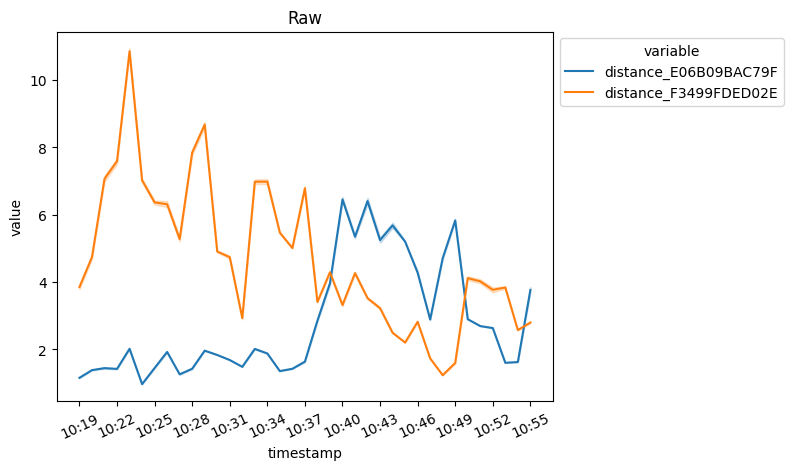

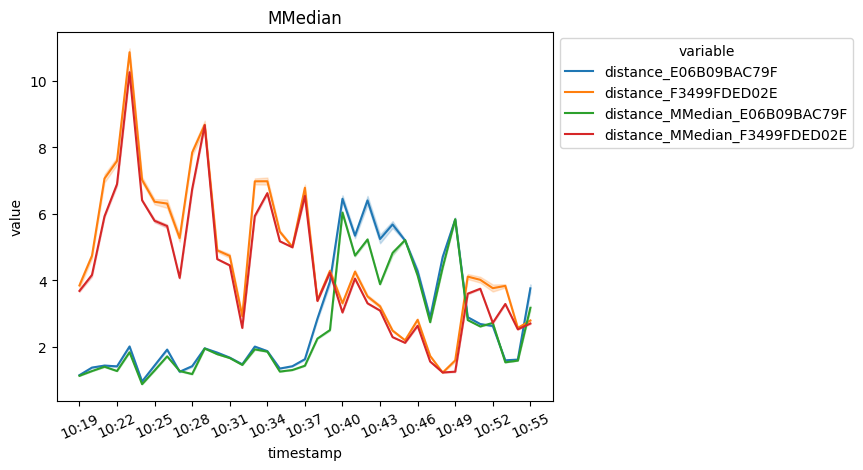

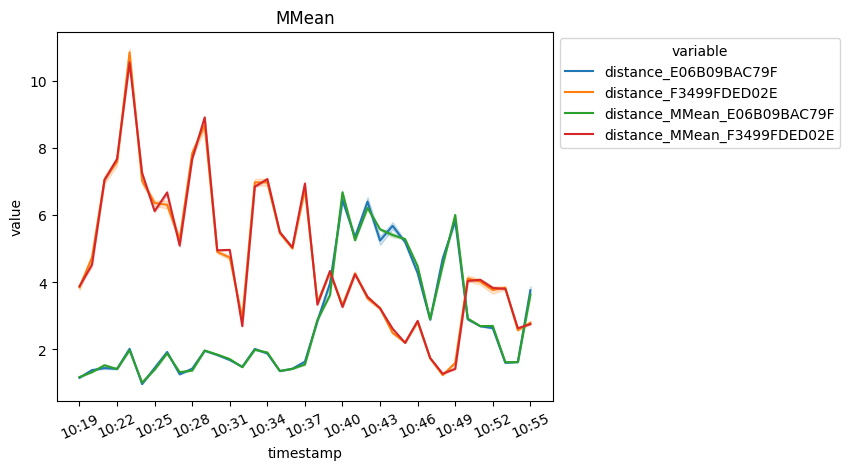

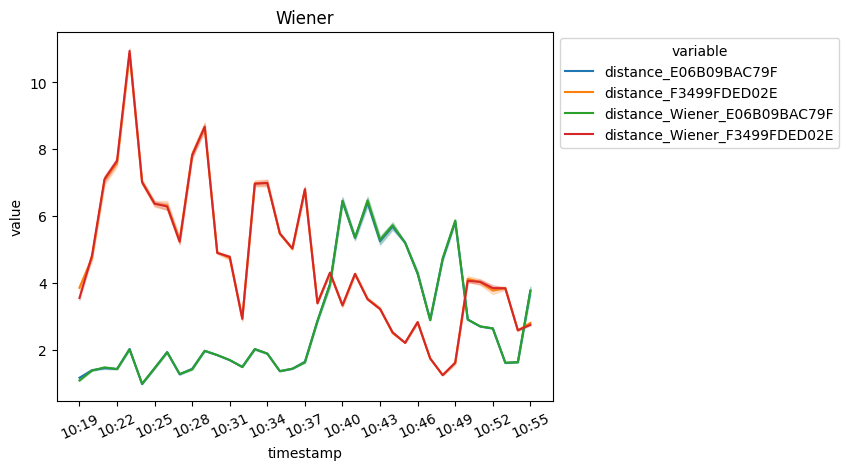

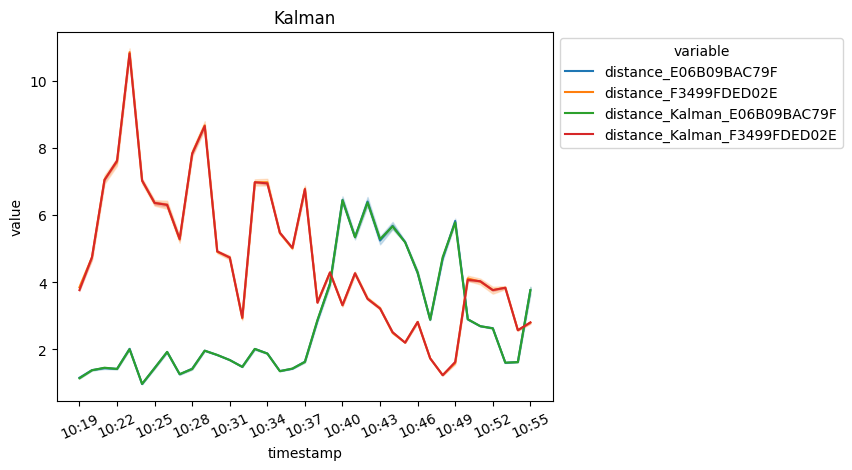

In [30]:
#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = master_df.majorminor.unique()[0]

for filter in dict_filter_distance_columns.keys():
  #Predefine column selection for plots
  column_selection = ['distance'] + [dict_filter_distance_columns.get(filter)] + ['timestamp']
  df = pd.DataFrame(columns=column_selection)
  for gateway in master_dict.keys():
    #Load data
    temp_df = master_dict.get(gateway).get('data')
    #Reducing entry for specified majorminor and columns
    temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
    #Casting timestamp to a certain format for illustration
    temp_df.timestamp = pd.to_datetime(temp_df.timestamp,unit='s').dt.strftime('%H:%M')
    #Preparation for different naming in plot
    temp_df = temp_df.rename(columns={c: c+'_'+gateway for c in temp_df.columns if c.startswith('distance')})
    if len(df) > 0:
      df = pd.merge(temp_df, df,on=['timestamp'],how='outer')
    else:
      df = temp_df
  #Used for df mutation for direct polting
  df = pd.melt(df, ['timestamp']).sort_values(['timestamp','variable'])
  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
                    data=df)
  #Setting three minutes jumps in timestamp and other stylings on x-axies 
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
  plt.title(filter)
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
  plt.show()


#Featureerweiterung (Feature Extraction)
In diesem Abschnitt werden aus den bestehenden Daten Features generiert. Dies soll ermöglichen, dass nicht nur ein Distanzeintrag an das Modell gesendet wird. So wird die Featureanzahl von 1 auf n erhöht.
Dabei werden verschiedene Anzahlen an zusätzlichen Features ausgetestet.

In [31]:
#Defines amount of additional feature values
#IMPORTANT 6 should be used as upper limit or otherwise with the current 
#dataset for training the number of datapoints has to be reduced
#Problem is, that knn distance calculation gets to complex, requires to much computing
#power (speifically RAM) which can lead to crash of the virtual google colab environmenet or
#index out of bound messages which lead to model performances of NAN as calculation gets aborted
enlargement_size = 6

#Predefines names and generates the column lists of new features
additonal_cols = []
timediff_cols = []
feature_cols = list(dict_filter_distance_columns.values())
for index in range(enlargement_size,0,-1):
  additonal_cols = additonal_cols + [sub +'-prev'+str(index) for sub in feature_cols]
  timediff_cols = timediff_cols + ['timediff-prev'+str(index)]

new_df = pd.DataFrame()

for gateway in master_dict.keys():
  df = master_dict.get(gateway).get('data')
  for majorminor in df.majorminor.unique():

    #Selects each beacon seperatly for clean data preparation
    temp_df = df.loc[df.majorminor == majorminor].copy().reset_index(drop=True)

    #Defines boundries for clean iteration through current dataframe
    lower_boundry = enlargement_size
    upper_boundry = len(temp_df)
    
    #Loops through whole dataset to add features
    for current_pos_index in range(lower_boundry,upper_boundry):
      ref_timestamp = temp_df.iloc[current_pos_index].timestamp
      ref_in_room = temp_df.iloc[current_pos_index].InRoom

      #Selects the n (enlargement_size) previous df entries before the current df entry
      df_section = temp_df.iloc[(current_pos_index - enlargement_size) : current_pos_index]

      #If Label InRoom is NOT the same it should lead to a sum of more than 0
      #in this case current iteration is skipped as it can not be used for training
      #Training should just contain previous data of the same label value
      if sum(df_section.InRoom != ref_in_room) > 0:
        continue

      #Current timestamp gets substracted of each entry seperatly
      timediffs = df_section.timestamp - ref_timestamp
      additional_features = df_section.loc[:,feature_cols]

      #Useage of col order and array transforming (reshaping) for direct assigning of values
      #As it is set for a single df entry shape has to be (n,1)
      temp_df.loc[temp_df.index == current_pos_index,timediff_cols] = timediffs.to_numpy().T
      temp_df.loc[temp_df.index == current_pos_index,additonal_cols] = additional_features.to_numpy().reshape(len(additonal_cols))       
        

      ##"Simpler" solution but extremly imperformant
      ##Above solution is 7 times faster

      #for index in range(1,enlargement_size+1):
        
      #  additional_features_index = current_pos_index - index
        #Abort current iteration as it should just use reference points within same label (InRoom)
      #  if (ref_in_room != temp_df.iloc[additional_features_index].InRoom):
      #    continue
      #  timediff = temp_df.iloc[additional_features_index].timestamp - ref_timestamp
        
      #  additonal_cols = [sub +'-prev'+str(index) for sub in feature_cols]
      #  distances = temp_df.loc[temp_df.index == additional_features_index,feature_cols]

      #  temp_df.loc[temp_df.index == current_pos_index,additonal_cols] = distances.to_numpy()
      #  temp_df.loc[temp_df.index == current_pos_index,['timediff-prev'+str(index)]] = timediff

    #Cleans df and drops all rows which contain a single nan value
    temp_df = temp_df.dropna()
    #Checks if df has already entries and has to be concated with them or new assigned
    if len(new_df) > 0:  
      new_df = pd.concat([new_df, temp_df], ignore_index=True)
    else:
      new_df = temp_df.copy()
  #Writes created data to master dictionary
  master_dict[gateway]['extended_data'] = new_df

#Machine Learning Algorithmen Training
Beinhaltet die unterschiedlichen Machine Learning Ansätze, welche für die Trainingsdatensätze geprüft werden.

Geplant: KNN, Naive Bayes, Support Vector Classifier (SVC) und Random Forest Classifier

In [8]:
#Set answer to every question as random state (as it is a number used for randomization)
#Seed can be set to any number but if the same number is used it can ensure that 
#randomness leads to the same behaviour when executed multiple times
random_state=42
dict_best_accuracy = dict.fromkeys(master_dict.keys(), [])

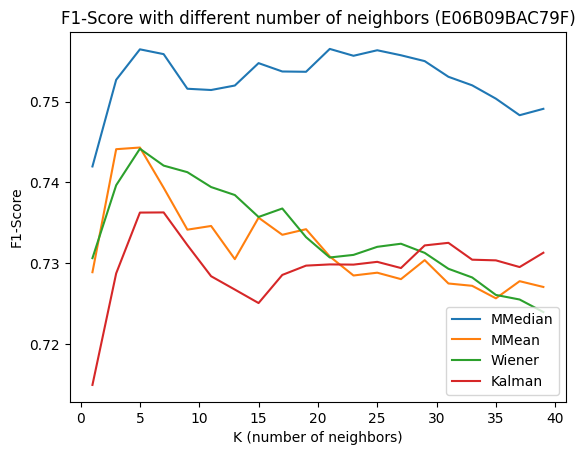

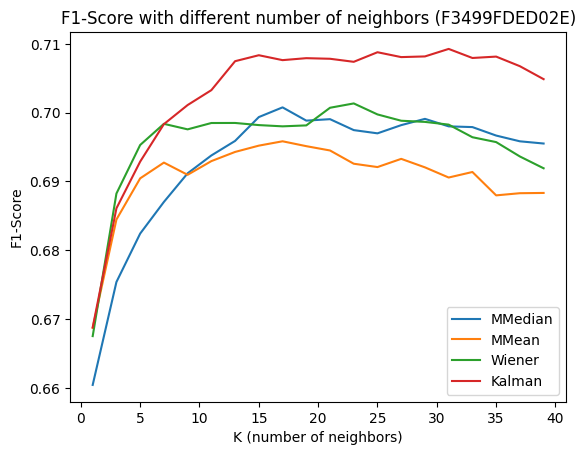

In [14]:
model = 'knn'

for gateway in master_dict.keys():
  #Loads limited amount of data due to errors (Session break downs and nan scoring values)
  #Required if additional feature extends 6 
  df = master_dict.get(gateway).get('extended_data')#.sample(20000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_accuracy = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  dict_best_accuracy[gateway][model] = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  k = []

  #Exclude Raw data as it leads to index out of bounds for knn algorithm
  #Has also lead to complet overload of the environement leading to a crash
  #of virual environement of google colab
  dict_accuracy.pop('Raw', None)
  dict_best_accuracy[gateway][model].pop('Raw', None)

  #Check different number of neighbors
  for n_neighbors in range(1, 40, 2):
    #Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    k.append(n_neighbors)

    for filter in dict_accuracy.keys():
      prefix = str(dict_filter_distance_columns.get(filter))
      column_selection = [col for col in df if (col.startswith(prefix) or col.startswith('timediff'))]

      X = df.loc[:,column_selection]
      Y = df.InRoom

      #Ensures that folds are shuffled to prevent overfitting
      kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

      #Calculates cross validation score 
      crossv_results = cross_val_score(knn, X, Y, cv=kfold, scoring='f1')

      #Append score to list categorised by filter for easy plotting
      dict_accuracy[filter] = dict_accuracy[filter] + [crossv_results.mean()]

      #Checks if the current k for the knn model with the given data (provided by a certain gateway and applied filter) is better than the previous model performance
      #if this is the case the current settings overwrite the previous settings
      if (len(dict_best_accuracy[gateway][model][filter])==0) or (dict_best_accuracy[gateway][model][filter]["best_score_"] < [crossv_results.mean()]) :
        dict_best_accuracy[gateway][model][filter] = {"best_score_": [crossv_results.mean()],
                                    "best_params_": {"n_neighbors": n_neighbors}}
  #Used for ploting a graph which shows the performance of the models
  #depending on number of neighbors with the given training / test data
  for key in dict_accuracy.keys():
    plt.plot(k, dict_accuracy[key])
  plt.ylabel("F1-Score")
  plt.xlabel("K (number of neighbors)")
  plt.legend(dict_accuracy.keys(), loc='lower right')
  plt.title("F1-Score with different number of neighbors ("+str(gateway)+")")
  plt.show()

In [33]:
model = 'svc'

#Define values of parameters to test for optimize model
#The reduced number of options in the parameters is due to several
#executions in which required options could be narrowed down
param_svc_grid = { 'C': [10, 100, 1000], 'gamma': [1, 0.1], 'kernel': ['rbf'] }

for gateway in master_dict.keys():
  #Loads data with additional features
  #Sample can be used if hypertuning time should be reduced (Could lead to not optimal hyperparameter)
  df = master_dict.get(gateway).get('extended_data')#.sample(8000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  #Create default instance of support vector classification model
  #Some default parameter values are changed in grid search further below by param_svc_grid above
  svc = SVC()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col.startswith(prefix) or col.startswith('timediff'))]

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    
    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    svc_grid = GridSearchCV(estimator=svc, param_grid=param_svc_grid, cv=kfold)
    #RandomizedSearchCV(estimator=svm, param_grid=param_svc_grid, cv=kfold, random_state=random_state, n_iter=10)
    svc_grid.fit(X, Y)

    print(filter)
    print(svc_grid.best_score_)
    print(svc_grid.best_params_)
    dict_best_accuracy[gateway][model][filter] = {"best_score_": svc_grid.best_score_,
                                                   "best_params_": svc_grid.best_params_}

E06B09BAC79F
Raw
0.8451257553956835
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
MMedian
0.8162627657873701
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
MMean
0.8048293525179856
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Wiener
0.8031505035971224
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Kalman
0.7956339568345323
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
F3499FDED02E
Raw
0.787125
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
MMedian
0.753875
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
MMean
0.7593749999999999
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Wiener
0.759
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Kalman
0.7556250000000001
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [27]:
model = 'nbayes'

#Define values of parameters to test for optimize model
param_grid_nb = { 'var_smoothing': np.logspace(0,-9, num=100) }

for gateway in master_dict.keys():
  #Loads data with additional features
  df = master_dict.get(gateway).get('extended_data')

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  #Create default instance of gaussian naive bayes classifier model
  #Some default parameter values are changed in grid search further below by param_grid_nb above
  gnb = GaussianNB()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col.startswith(prefix) or col.startswith('timediff'))]

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    gnb_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=kfold)
    gnb_grid.fit(X, Y)

    print(filter)
    print(gnb_grid.best_score_)
    print(gnb_grid.best_params_)
    dict_best_accuracy[gateway][model][filter] = {"best_score_": gnb_grid.best_score_,
                                                   "best_params_": gnb_grid.best_params_}

E06B09BAC79F
Raw
0.7255130295763389
{'var_smoothing': 0.0001}
MMedian
0.7403856115107914
{'var_smoothing': 0.0001232846739442066}
MMean
0.7233545643485212
{'var_smoothing': 0.0005336699231206307}
Wiener
0.7143186570743405
{'var_smoothing': 6.579332246575683e-05}
Kalman
0.7222348840927258
{'var_smoothing': 0.0008111308307896872}
F3499FDED02E
Raw
0.6975633340532044
{'var_smoothing': 3.511191734215127e-05}
MMedian
0.7096430120957778
{'var_smoothing': 0.0008111308307896872}
MMean
0.7005024342663769
{'var_smoothing': 1.873817422860383e-06}
Wiener
0.6944630573244278
{'var_smoothing': 0.0006579332246575676}
Kalman
0.6998984722522168
{'var_smoothing': 0.0002310129700083158}


In [33]:
model = 'rforest'

#Define values of parameters to test for optimize model
#The reduced number of options in the parameters is due to several
#executions in which required options could be narrowed down
n_estimators = [1200, 1500]
max_depth = [15, 30]
param_grid_rf = dict(n_estimators = n_estimators, max_depth = max_depth, random_state = [random_state])

for gateway in master_dict.keys():
  #Loads data with additional features
  df = master_dict.get(gateway).get('extended_data').sample(10000)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model] = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  #Create default instance of random forest classifier model
  #Some default parameter values are changed in grid search further below by param_grid_rf above
  rf = RandomForestClassifier()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col.startswith(prefix) or col.startswith('timediff'))]

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=kfold)
    rf_grid.fit(X, Y)

    print(filter)
    print(rf_grid.best_score_)
    print(rf_grid.best_params_)
    #Stores result in dictionary seperated by gateway, model and filter
    dict_best_accuracy[gateway][model][filter] = {"best_score_": rf_grid.best_score_,
                                                   "best_params_": rf_grid.best_params_}

F3499FDED02E
Raw
0.8455
{'max_depth': 30, 'n_estimators': 1500, 'random_state': 42}
MMedian
0.8093
{'max_depth': 30, 'n_estimators': 1500, 'random_state': 42}
MMean
0.7841
{'max_depth': 30, 'n_estimators': 1200, 'random_state': 42}
Wiener
0.7903
{'max_depth': 30, 'n_estimators': 1200, 'random_state': 42}
Kalman
0.7747999999999999
{'max_depth': 15, 'n_estimators': 1500, 'random_state': 42}


#Überspringung ML Hyperparameter Training (Zuweisung der erhobener Ergebnisse)
Dieser Abschnitt wird genutzt um den rechen- und zeitintensiven Schritt der Hyperparameter Optimierung der Modelle des vorherigen Abschnitts zu überspringen.

In [32]:
dict_best_accuracy = {'E06B09BAC79F': {'knn': {'MMedian': {'best_score_': [0.7565416745670983],
    'best_params_': {'n_neighbors': 21}},
   'MMean': {'best_score_': [0.7443306511908068],
    'best_params_': {'n_neighbors': 5}},
   'Wiener': {'best_score_': [0.7441824404577234],
    'best_params_': {'n_neighbors': 5}},
   'Kalman': {'best_score_': [0.736293435556942],
    'best_params_': {'n_neighbors': 7}}},
  'svc': {'Raw': {'best_score_': 0.8451257553956835,
    'best_params_': {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.8162627657873701,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.8048293525179856,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.8031505035971224,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.7956339568345323,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7255130295763389,
    'best_params_': {'var_smoothing': 0.0001}},
   'MMedian': {'best_score_': 0.7403856115107914,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'MMean': {'best_score_': 0.7233545643485212,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'Wiener': {'best_score_': 0.7143186570743405,
    'best_params_': {'var_smoothing': 6.579332246575683e-05}},
   'Kalman': {'best_score_': 0.7222348840927258,
    'best_params_': {'var_smoothing': 0.0008111308307896872}}},
  'rforest': {'Raw': {'best_score_': 0.9074918713569728,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1500,
     'random_state': 42}},
   'MMedian': {'best_score_': 0.8706318911284407,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1200,
     'random_state': 42}},
   'MMean': {'best_score_': 0.8369717181073215,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1500,
     'random_state': 42}},
   'Wiener': {'best_score_': 0.8356926454038689,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1200,
     'random_state': 42}},
   'Kalman': {'best_score_': 0.8220206082235372,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1500,
     'random_state': 42}}}},
 'F3499FDED02E': {'knn': {'MMedian': {'best_score_': [0.7007708075099413],
    'best_params_': {'n_neighbors': 17}},
   'MMean': {'best_score_': [0.6958423554917232],
    'best_params_': {'n_neighbors': 17}},
   'Wiener': {'best_score_': [0.7013441400470115],
    'best_params_': {'n_neighbors': 23}},
   'Kalman': {'best_score_': [0.7092648251785868],
    'best_params_': {'n_neighbors': 31}}},  
  'svc': {'Raw': {'best_score_': 0.787125,
    'best_params_': {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}},  
   'MMedian': {'best_score_': 0.753875,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.7593749999999999,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.759,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.7556250000000001,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.6975633340532044,
    'best_params_': {'var_smoothing': 3.511191734215127e-05}},
   'MMedian': {'best_score_': 0.7096430120957778,
    'best_params_': {'var_smoothing': 0.0008111308307896872}},
   'MMean': {'best_score_': 0.7005024342663769,
    'best_params_': {'var_smoothing': 1.873817422860383e-06}},
   'Wiener': {'best_score_': 0.6944630573244278,
    'best_params_': {'var_smoothing': 0.0006579332246575676}},
   'Kalman': {'best_score_': 0.6998984722522168,
    'best_params_': {'var_smoothing': 0.0002310129700083158}}},
  'rforest': {'Raw': {'best_score_': 0.8455,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1500,
     'random_state': 42}},
   'MMedian': {'best_score_': 0.8093,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1500,
     'random_state': 42}},
   'MMean': {'best_score_': 0.7841,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1200,
     'random_state': 42}},
   'Wiener': {'best_score_': 0.7903,
    'best_params_': {'max_depth': 30,
     'n_estimators': 1200,
     'random_state': 42}},
   'Kalman': {'best_score_': 0.7747999999999999,
    'best_params_': {'max_depth': 15,
     'n_estimators': 1500,
     'random_state': 42}}}}}

#Performanceanalyse, Bildliche Aufbereitung
In diesem Abschnitt werden die Modellem mit den ermittelten optimalen Hyperparameter analysiert und aufgezeigt.

Dazu werden Confusionsmatrizen und ROC Curves erstellt.

In [10]:
#Set answer to every question as random state (as it is a number used for randomization)
#Seed can be set to any number but if the same number is used it can ensure that 
#randomness leads to the same behaviour when executed multiple times
random_state=42

In [33]:
def plot_confusionmatrix (trained_model, X_test, y_test):
  #Testing the model using X_test and storing the output in y_pred
  y_pred = trained_model.predict(X_test)

  #Creating a confusion matrix,which compares the y_test and y_pred
  cm = confusion_matrix(y_test, y_pred)

  #Creating a dataframe for a array-formatted Confusion matrix (easier for plotting)
  cm_df = pd.DataFrame(cm)

  #Plotting the confusion matrix
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()


In [34]:
#Defined funciton which can be used to plot multiple models on a single roc curve diagramm
def plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test):
  plt.figure(0).clf()
  for model_name in dict_with_trained_models.keys():
    trained_model = dict_with_trained_models.get(model_name)
    y_pred = trained_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=str(model_name) + ", AUC=" + str(auc))
  plt.show()

In [31]:
for gateway in dict_best_accuracy.keys():

  for model in dict_best_accuracy[gateway].keys():
  
    for filter in dict_best_accuracy[gateway][model].keys():
      params = dict_best_accuracy[model][filter]["best_params_"]
      #Current Python version of notebook does not support match case (swith case)
      if model == "knn":
        #** is used to unpack dictionary of params
        model = KNeighborsClassifier(**params)
      elif model ==  "svc":
        model = SVC(**params)
      elif model ==  "nbayes":
        model = GaussianNB(**params)
      elif model ==  "rforest":
        model = RandomForestClassifier(**params)
      else:
        print("Model ("+model+") not definied")

      prefix = str(dict_filter_distance_columns.get(filter))
      column_selection = [col for col in df if (col.startswith(prefix) or col.startswith('timediff'))]

      X = df.loc[:,column_selection]
      Y = df.InRoom

      model.fit(X,Y)
      #model is added to dictionary
      dict_best_accuracy[gateway][model][filter]["model"] = model

dict_keys(['knn', 'svc', 'nbayes', 'rforest'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['MMedian', 'MMean', 'Wiener', 'Kalman'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
dict_keys(['best_score_', 'best_params_'])
